In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from monte_carlo import Monte_carlo_dla
import numpy as np
import matplotlib.pyplot as plt
import random

# A)

In [50]:
grid = SimulationGrid(100)
position = [5, 5]

x = grid.growth_model(position, 1.9, 0.3, stop = 0.0001, store_step = 10000)
x

<generator object SimulationGrid.growth_model at 0x000001D404EABD30>

In [51]:
if __name__ == "__main__":

    from methods import jacobi, sor, gauss_seidel


import numpy as np

import math

import matplotlib.pyplot as plt

import matplotlib.animation as animation

from scipy.sparse import diags

from scipy.sparse import csr_matrix


class SimulationGrid:


    def __init__(self, N, D = 1):
        """

        Creates a simulation grid.

        Inputs:

            - N: How many intervals divide space

            - D: Parameter , default set to 1

            - object_: Matrix that specifies sink points. 0 means the state changes, 1 means it does not and it is fixde
        """

        self.D = 1

        self.dx = 1/N

        self.N = N

        self.initialize()

        self.data = [self.A] #For simulations

        self.data_especial = [] #To store the time at 0.1,0.001,....

        self.particles = np.zeros((self.N+1,self.N+1))




    def initialize(self):
        """
        Initializes matrix with all all 0 concentrations except 1 on first row
        object_ matrix specifies which points need to be updated
        """

        A = np.zeros((self.N+1, self.N+1))

        A[0,:] = 1

        self.A = A


        object_ = np.copy(A)

        object_[-1,:] = 1

        self.object_ = object_
    

    def square(self, size, position):
        """

        Puts a square of a specific size, the grid.

        Inputs:

            - size: Size of the square

            - position: Upper left vertex of the square position
        """

        if (size + position[0]) >= (self.N-1) or (size + position[1]) >= (self.N-1) :

            raise Exception ("Object does not fit") 

        self.object_[position[0]:position[0]+size,position[1]:position[1]+size]  = np.ones((size, size))
    
       
    
    def dla(self,position):
        """

        Creates a sink point for DLA.

        Inputs:

            - position: Tuple of two points
        """

        if (position[0]) >= (self.N-1) or (position[1]) >= (self.N-1) :

            raise Exception ("Outside bounds")

        self.object_[position[0], position[1]] = 1



    def time_independent(self,method_fun,*args,stop = 0.00001, **kwargs):
        """

        Executes a time_step ing method given a function

        Inputs:

            - method_func: Method to use function

            - stop: Stopping criteria

            - store_step: Every how many steps store data
        """

        self.data = [self.A]

        C = np.copy(self.A)

        n_count = 0

        self.iterations = []

        for A_t in method_fun(*args, C=C,stop=stop,object_ = self.object_,**kwargs):

            self.data.append(np.copy(A_t[0]))

            self.iterations.append(A_t[1])

    

    def time_dependent_matrix(self):
        """

        Creates the matrices for time dependent difference scheme
        """


        diagonals = [np.ones(self.N), np.ones(self.N)]
        M1 = diags(diagonals , [-1, 1])
        M2 = diags(diagonals, [-1,1]).toarray()


        ## Cyclic boundary conditions

        M2[-2,0] = 1
        M2[1,-1] = 1

        ## Periodic boundary conditions

        self.M1 = M1

        self.M2 = M2


    def time_dependent_step(self,C):
        """

        Does on step of the time dependent difference scheme

        Inputs:

            - C: Matrix C, which is A over time

        Outputs:

            - C: Matrix C after one step
        """

        c1=  self.M1@C

        c2 = C@self.M2

        non_cte = np.where(self.object_ == 0)

        C[non_cte[0],non_cte[1]] = (C + self.term*(c1 + c2 - 4*C))[non_cte[0],non_cte[1]]

        return C
    

    

    def time_dependent(self,t,dt = 0.0001, time_list = [0.001,0.01,0.1,1.0]):
        """

        Does time dependent stepping scheme.

        Inputs:

            - t: total time

            - dt: Time step in seconds

            - time_list: times to store
        """

        self.data = [self.A]

        self.term = (dt*self.D)/(self.dx**2)

        self.time_dependent_matrix()


        if 4*self.term > 1:

            raise Exception ("Not stable system")


        C = np.copy(self.A)

        n_steps = int(t/dt)



        for k in range(n_steps):

            C = self.time_dependent_step(C)

            if k%20 == 0:

                self.data.append(np.copy(C))

            if k*dt in time_list:

                self.data_especial.append(np.copy(C))

                print(k*dt)

            if k == n_steps -1:

                self.data_especial.append(np.copy(C))



    def c_analytical(self,t, i_max=100):
        """

        Returns analytical solution of diffusion equation

        Inputs:

            - y: y axis solution

            - t: time period
        """

        lst = []

        y = np.linspace(0,1,self.N)

        for y_i in y:

            result = 0

            for i in range(i_max):

                arg1 = math.erfc((1 - y_i + (2*i)) /(2 * np.sqrt(self.D*t)))

                arg2 = math.erfc((1 + y_i + (2*i)) /(2 * np.sqrt(self.D*t)))

                result += (arg1-arg2)

            lst.append(result)

        return np.array(lst)


    def animation(self,method,method_fun = None,t = 1.5,save_animation = False):
        """

        Animates the stepping scheme:

        Inputs:
s
            -   method: If using time_dependent or time_independent

            -   method_fun: If time_independent, which method to use

            -   t: Total animation time

            -   dt: Time stepping size

            -   save_animation: True == it will save the animation, default is False
        """

        fig, ax = plt.subplots()       

        C = np.copy(self.A)

        if method == "time_dependent":
            self.time_dependent(t)

        elif method == "time_independent":

            self.time_independent(method_fun)
        n_steps = len(self.data)
        

        C = np.copy(self.A)
        

        ax.imshow(C, cmap='hot', interpolation='nearest', extent=[0, 1, 0, 1])

        ax.set_xlabel('X')  

        ax.set_ylabel('Y')  

        ax.set_title('Time: 0 s') 
        

        anim = animation.FuncAnimation(fig,self.frame, fargs= (ax,), frames=int(n_steps), interval = 0.000000001)


        if save_animation == True:

            print("Starting ")

            anim.save('time_dependent_diffusion_animation.mp4', fps=60)
            plt.close()


    def frame(self, iteration, ax):

        C = self.data[iteration]

        ax.clear()

        ax.set_title(f'Time dependent(t={np.round(iteration*0.0001*50, 7)}) s')

        ax.imshow(C, cmap='hot', interpolation='nearest', extent=[0, 1, 0, 1])


    def growth_model(self, position, w, eta, stop, store_step=1):
        if (position[0]) >= (self.N - 1) or (position[1]) >= (self.N - 1):
            raise Exception("Outside bounds")

        self.data = [self.A]

        self.object_[position[0], position[1]] = 1

        n_count = 0
        

        while True:
            
            non_cte = np.where(self.object_ == 0)
            n_count += 1
            C_b = np.copy(self.data)
            for i in len(non_cte):
                if i != 0 and i != self.N - 1: 
                    if non_cte[1][j] == 0:
                        self.data[i, 0] = (w / 4) * (self.data[i + 1, 0] + self.data[i - 1, 0] + self.data[i, 1] + self.data[i, -2]) + (1 - w) * self.data[i, 0]
                    elif non_cte[1][j] == (self.N - 1):
                        self.data[i, -1] = (w / 4) * (self.data[i + 1, -1] + self.data[i - 1, -1] + self.data[i, 1] + self.data[i, -2]) + (1 - w) * self.data[i, -1]
                    else:
                        non_cte[1][j] = (w / 4) * (self.data[i + 1, j] + self.data[i - 1, j] + self.data[i, j + 1] + self.data[i, j - 1]) + (1 - w) * self.data[i, j]
                    
            sink = np.where(self.object_ == 1)

            for k in range(len(sink[0])):
                a = sink[0][k]
                b = sink[1][k]

                if a == 0:
                    u = 0
                if a == self.N - 1:
                    d = 0
                if b == 0:
                    l = 0
                if b == self.N - 1:
                    r = 0

                if a != 0:
                    if self.object_[a - 1, b] == 1:
                        u = 0
                if a != self.N - 1:
                    if self.object_[a + 1, b] == 1:
                        d = 0
                if b != 0:
                    if self.object_[a, b - 1] == 1:
                        l = 0
                if b != self.N - 1:
                    if self.object_[a, b + 1] == 1:
                        r = 0

                if u != 0:
                    u = self.data[a - 1, b] ** eta
                if d != 0:
                    d = self.data[a + 1, b] ** eta
                if l != 0:
                    l = self.data[a, b - 1] ** eta
                if r != 0:
                    r = self.data[a, b + 1] ** eta

                if (d + u + l + r) != 0:
                    for i in [a - 1, a + 1]:
                        for j in [b - 1, b + 1]:
                            if self.data[i, j] / (d + u + l + r) > random():
                                self.data[i, j] = 1
                                self.object_[i, j] = 1

            if np.allclose(self.data, C_b, atol=stop):
                yield (self.data, n_count)
                break
            if n_count % store_step == 0:
                yield (self.data, n_count)
        
        ax.clear()

        #ax.set_title(f'Time dependent(t={np.round(iteration*0.0001*50, 7)}) s')

        ax.imshow(C, cmap='', interpolation='nearest', extent=[0, 1, 0, 1])
        
        return self.data



    

## B)

In [2]:
N = 100
n_particles = 20_000
p_list = np.linspace(0,1,num = 4)

In [5]:
monte_carlos = black_scholes = np.vectorize(Monte_carlo_dla, excluded=['N', 'n_particles'])(N,n_particles,p_list)

In [6]:
values = []
for i in monte_carlos:
    values += [i.A]
values = np.array(values)

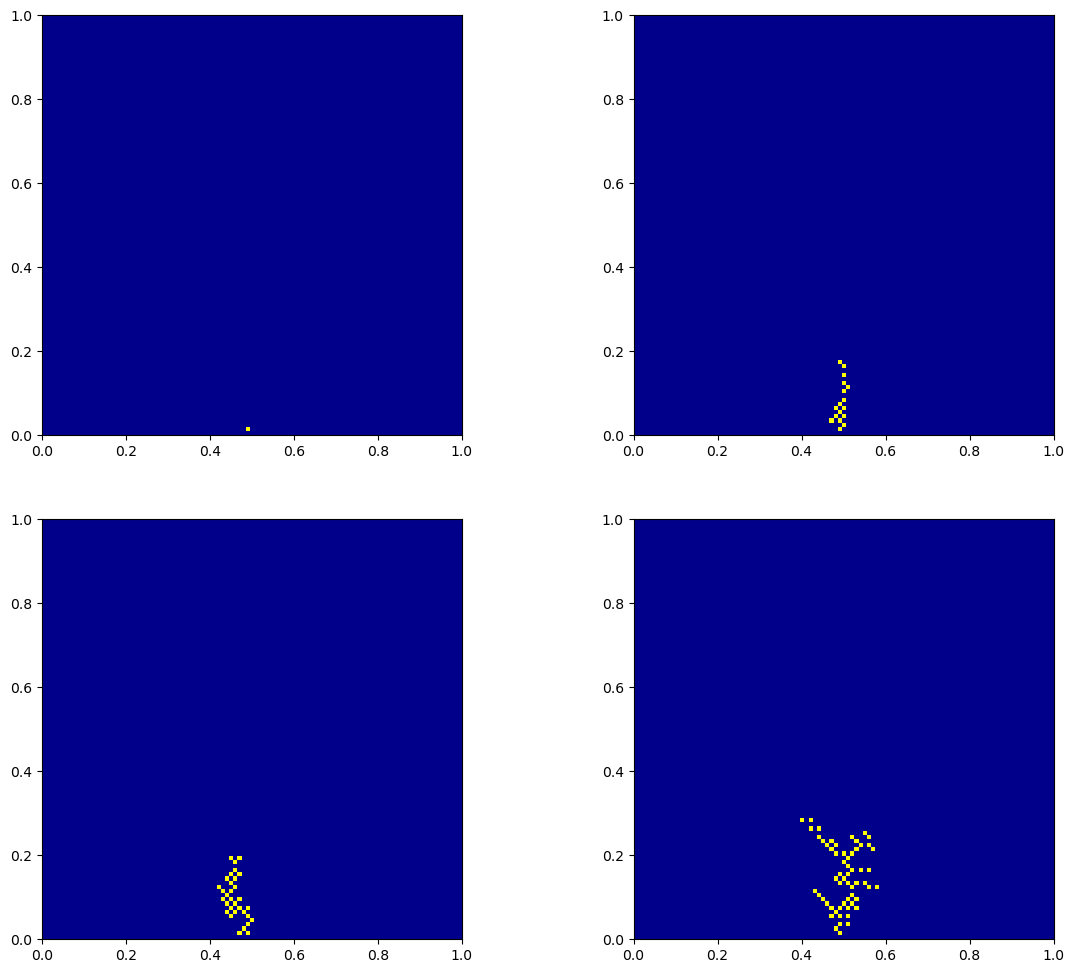

In [14]:
fig,axs = plt.subplots(2,2, figsize = (14,12))
axs = axs.flatten()

for i,ax in enumerate(axs):
    ax.imshow(values[i][1:-1, 1:-1], cmap= plt.cm.colors.ListedColormap(['darkblue', 'white', 'yellow']), interpolation='nearest', extent=[0, 1, 0, 1])